In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx

In [29]:
"""
Helper function for clustering
"""
import scipy.cluster.hierarchy as spc

def hierarchical_clustering(H, alpha=0.7):
    """
    Standard hierarchical clustering, using scipy

    ARGUMENTS

        H       :   (# hidden states, # neurons)-numpy array representing
                    hidden states of the RNN

    RETURNS

        order   :   (# neurons,)-numpy array. order[i] denotes the index of
                    neuron i, based on the order imposed by the hierarchical
                    clustering
    """
    # Covariance matrix
    corr = (H.T @ H) / H.shape[0]

    # Pairwise distanced, based on neuron-neuron correlation vectors
    pdist = spc.distance.pdist(corr)
    # Hierarchical Clustering
    linkage = spc.linkage(pdist, method='complete')
    # Convert to cluster indices
    idx = spc.fcluster(linkage, alpha * pdist.max(), 'distance')
    order = np.argsort(idx)

    # Return the new neuron ordering
    return order

In [30]:
"""
Parameters
"""
# Network parameters
n_rings = 200    # Number of rings in the network
ring_size = 6    # Number of neurons per ring
eps = 0.95        # Coupling constant
p = 0.1   #Two rings are connected with probability p

# Simulation parameters
dt = 1e-2        # Simulation timestep
T_sim = 200       # Simulation duration
seed = -1        # Random seed for the simulation

# Neuron parameters
v_thl = 0.2      # Lower threshold of the schmidt trigger
v_thh = 0.49     # Upper threshold of the schmidt trigger

# Initialization parameters
dv = 1e-2        # Controls the randomness in the initial state
dt_init = 1e-3   
T_init_max = 2 * ring_size

# Random seed
if seed == -1: seed = np.random.randint(1e6)
print('Random Seed:', seed)
np.random.seed(seed)

# Setup arrays to store the simulation history
n_ts = int(T_sim / dt) + 1 # Number of timesteps in the simulation
v_cap = np.empty((n_ts,n_rings,ring_size), dtype=float)
v_out = np.empty((n_ts,n_rings,ring_size), dtype=float)

# Schmidt trigger "Activation function"
def f_out(o, v):
     return 1 - np.logical_or( v >= v_thh, np.logical_and(v >= v_thl, o == 0)  )


"""
Initialization of the rings
"""

# Set the initial state
init_phase = np.random.rand(n_rings)
v_cap[0].fill(0.9)
v_out[0].fill(1)

# Randomly select a single node in each ring to be firing initially 
firing_nodes = np.random.choice(ring_size, size=n_rings)

# Set the selected nodes to have output 1 and random low capacitor values
v_cap[0,np.arange(n_rings),firing_nodes] = 0.1 + dv * np.random.rand(n_rings)
v_out[0,np.arange(n_rings),firing_nodes] = 0

# Simulate each ring *on its own* for a random amount of time
T_init = np.random.rand(n_rings) * T_init_max
alph_init = np.exp(-dt_init / T_init * T_init_max)
n_ts_init = int(T_init_max / dt_init)
for t in range(n_ts_init):
    # Update capacitors
    u = np.roll(v_out[0], 1, axis=1)
    v_cap[0] = v_cap[0] * alph_init[:,None] + u * (1-alph_init)[:,None]
    # Update outputs
    v_out[0] = f_out(v_out[0], u - v_cap[0])

"""
Simulation
"""
alph = np.exp(-dt)

## Randomly connected graph
# W = np.random.binomial(1, p, size = (n_rings, n_rings))
# np.fill_diagonal(W, 0)

#Watts Strogatz Small World Graph
G = nx.watts_strogatz_graph(n = n_rings, k = 5, p = p)
W = nx.to_numpy_array(G)
# Running the simulation loop
for t in range(n_ts-1):
    # Update capacitors
    # u = np.roll(
    #     v_out[t] + eps * v_out[t].mean(axis=0),
    #     1,
    #     axis=1
    # )
    # Input u *only* for this timestep

    # Input from within the ring. np.roll makes it so that neuron j
    #   receives input from neuron j-1
    u = np.roll(v_out[t], 1)  
    # Input external to the ring. Only neurons (i,1) receives external input
    #  and this is a linear combination of the outputs of neurons (j,0) for j != i 

    # Calculate row sums
    row_sums = np.sum(W, axis=1)

    # Identify rows with non-zero row sums
    non_zero_rows = row_sums != 0

    #Normalize W
    normalized_W = np.where(non_zero_rows[:, np.newaxis], W / row_sums[:, np.newaxis], W)
    u[:,1] += normalized_W @ v_out[t,:,0] * eps
    
    # Update the capacitor voltage
    v_cap[t+1] = alph * v_cap[t] + (1-alph) * u
    # Update outputs
    v_out[t+1] = f_out(v_out[t], u - v_cap[t+1])
    

Random Seed: 985334


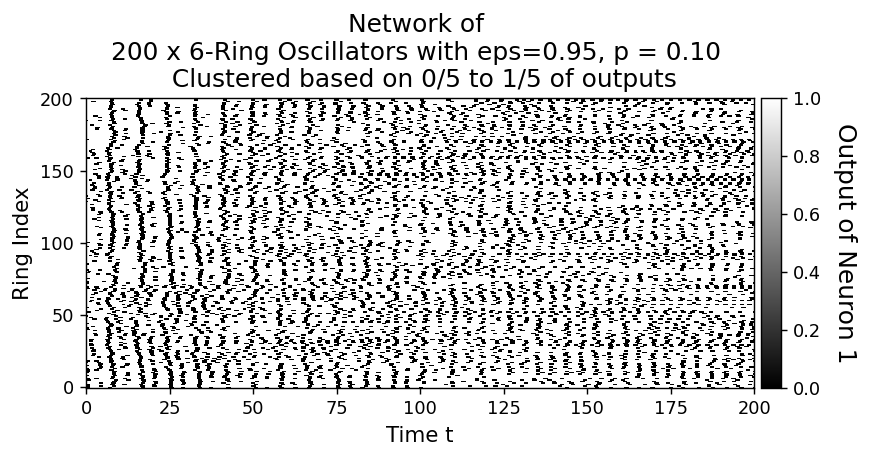

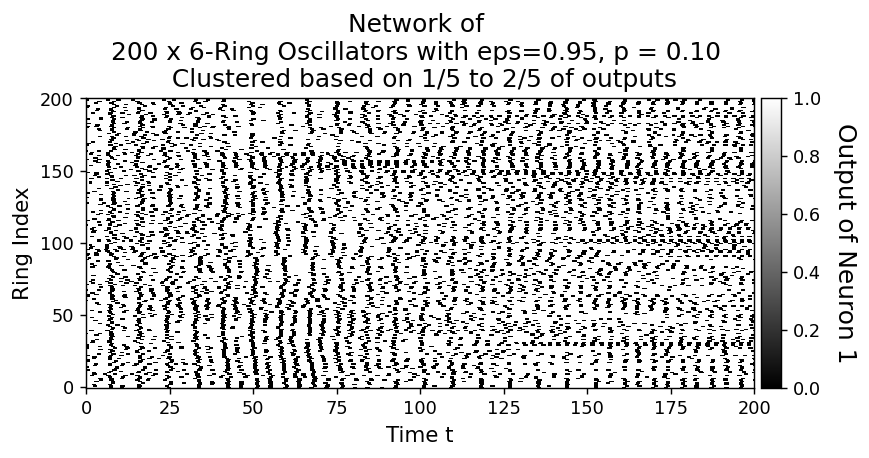

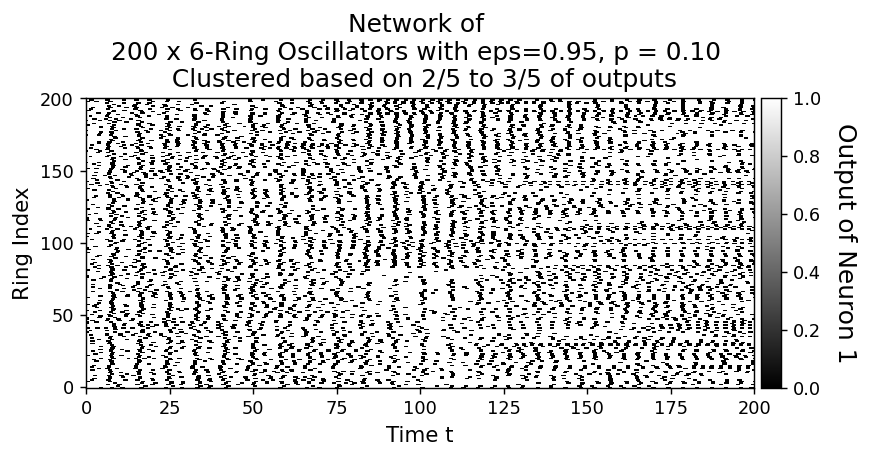

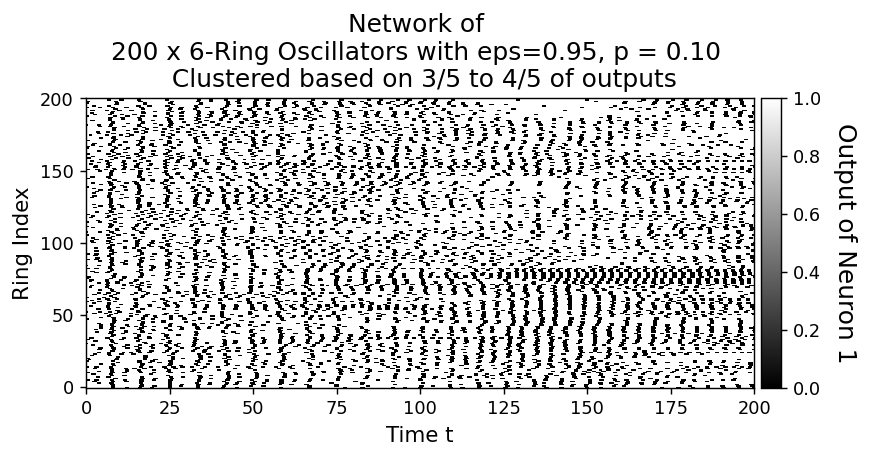

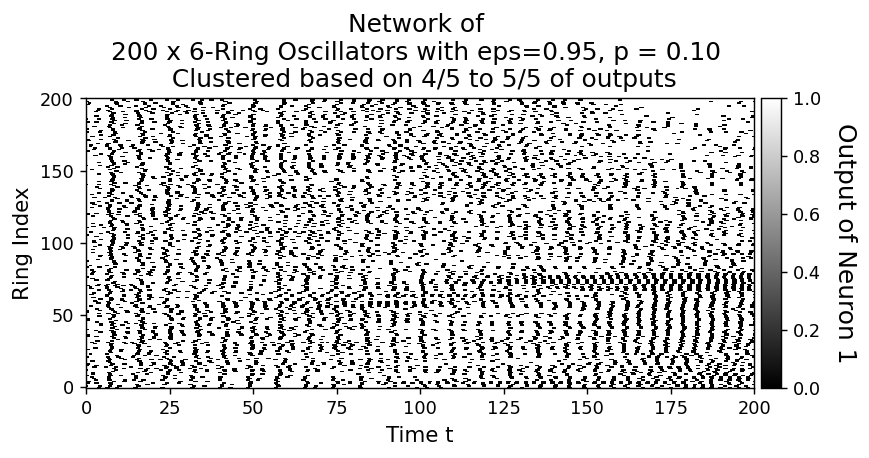

In [31]:
"""
Visualization of the results
"""
for i in range(5):
    order = hierarchical_clustering(v_out[i*n_ts//5:(i + 1)*n_ts//5: , : , 0], alpha=0.2)
    plt.figure(figsize=(7,3), dpi=128)
    plt.title('Network of \n%d x %d-Ring Oscillators with eps=%0.2f, p = %0.2f \n Clustered based on %d/5 to %d/5 of outputs' % (n_rings, ring_size, eps, p, i, i + 1), size=14)
    plt.xlabel('Time t', size=12)
    plt.ylabel('Ring Index', size=12)
    # Heatmap
    im = plt.imshow(
        v_out[:,order,0].T, 
        extent=(0,T_sim,-0.5,n_rings+0.5),
        aspect='auto', interpolation='none', vmin=0, vmax=1, cmap='binary_r'
    )
    # colorbar
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.ax.set_ylabel('Output of Neuron 1', size=14, rotation=-90, labelpad=20)

    plt.show()



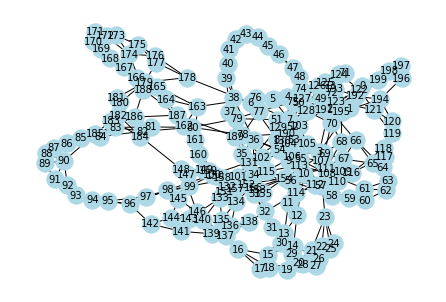

In [32]:
"""
Visualization of adjacency matrix W
"""
# digraph = nx.DiGraph()
# G = nx.from_numpy_array(W, create_using = digraph)

# Draw the graph
nx.draw(G, with_labels=True, node_size=300, font_size=10, node_color='lightblue')

# Show the graph
plt.show()
